# 載入套件

In [1]:
# !pip install xgboost

In [2]:
# !pip install lightgbm

In [3]:
# !pip install catboost 

In [4]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)
random.seed(1001)

# 讀取資料

In [5]:
x_train = pd.read_csv("X_train.csv", usecols=lambda column: column != 'Id')
y_train = pd.read_csv("y_train.csv", usecols=lambda column: column != 'Id')
x_test = pd.read_csv("X_test.csv", usecols=lambda column: column != 'Id')

In [6]:
print(f"Training df shape = {x_train.shape}; test df shape = {x_test.shape}")

Training df shape = (9460, 41); test df shape = (2366, 41)


In [7]:
x_train.head(5)

,鄉鎮市區,交易標的,路名,土地移轉總面積平方公尺,都市土地使用分區,土地數,建物數,車位數,移轉層次,移轉層次項目,總樓層數,建物型態,主要用途,主要建材,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,交易年,交易日,交易月,地鐵站,超商,公園,托兒所,國小,國中,高中職,大學,金融機構,醫院,大賣場,超市,百貨公司,警察局,消防局,縱坐標,橫坐標
0,文山區,房地(土地+建物)+車位,興隆路三段,27.75,住,1.0,1.0,1.0,1,無,7.0,華廈(10層含以下有電梯),見其他登記事項,鋼筋混凝土造,2019-10-16,133.43,3,2,2,有,有,2019,31,8,1.0,7.0,2.0,20.0,20.0,19.0,12.0,17.0,15.0,20.0,7.0,20.0,13.0,20.0,16.0,24.957269,121.588026
1,中正區,房地(土地+建物),金山南路一段,9.57,第三種住宅區,1.0,1.0,0.0,5,無,6.0,華廈(10層含以下有電梯),住家用,鋼筋混凝土造,1997-08-20,40.34,1,1,1,有,有,2021,8,1,1.0,12.0,8.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,20.0,24.997141,121.558262
2,文山區,房地(土地+建物),秀明路一段,9.51,住,1.0,1.0,0.0,1,無,7.0,套房(1房1廳1衛),住家用,鋼筋混凝土造,2009-05-13,70.61,1,1,1,有,有,2020,29,4,0.0,6.0,7.0,20.0,20.0,18.0,11.0,19.0,15.0,18.0,6.0,20.0,11.0,20.0,13.0,24.953906,121.601050
3,內湖區,房地(土地+建物)+車位,康樂街,23.67,第三種住宅區,1.0,1.0,1.0,10,無,15.0,住宅大樓(11層含以上有電梯),見其他登記事項,鋼筋混凝土造,2009-04-24,143.83,3,2,2,有,有,2019,5,6,1.0,12.0,14.0,20.0,20.0,14.0,5.0,4.0,19.0,20.0,12.0,20.0,13.0,20.0,15.0,25.008046,121.557424
4,北投區,房地(土地+建物),公路,22.50,第三種住宅區,1.0,1.0,0.0,2,無,5.0,公寓(5樓含以下無電梯),住家用,鋼筋混凝土造,1973-02-15,83.73,2,1,1,有,無,2021,8,4,2.0,4.0,13.0,20.0,20.0,15.0,5.0,15.0,19.0,20.0,10.0,20.0,16.0,18.0,13.0,24.986825,121.557424


## 繪製熱力圖

<Axes: xlabel='橫坐標', ylabel='縱坐標'>

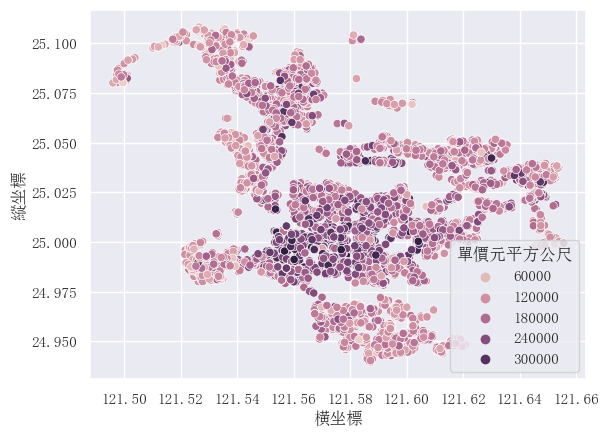

In [8]:
train_df = pd.concat([x_train, y_train], axis = 1)
sns.set(font="SimSun")
sns.scatterplot(train_df, x="橫坐標", y="縱坐標", hue = "單價元平方公尺")

In [9]:
# 使圖表能正常顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

C:\Users\jackyfirst\AppData\Local\Temp\ipykernel_11112\2164449720.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = x_train.corr()


<Axes: >

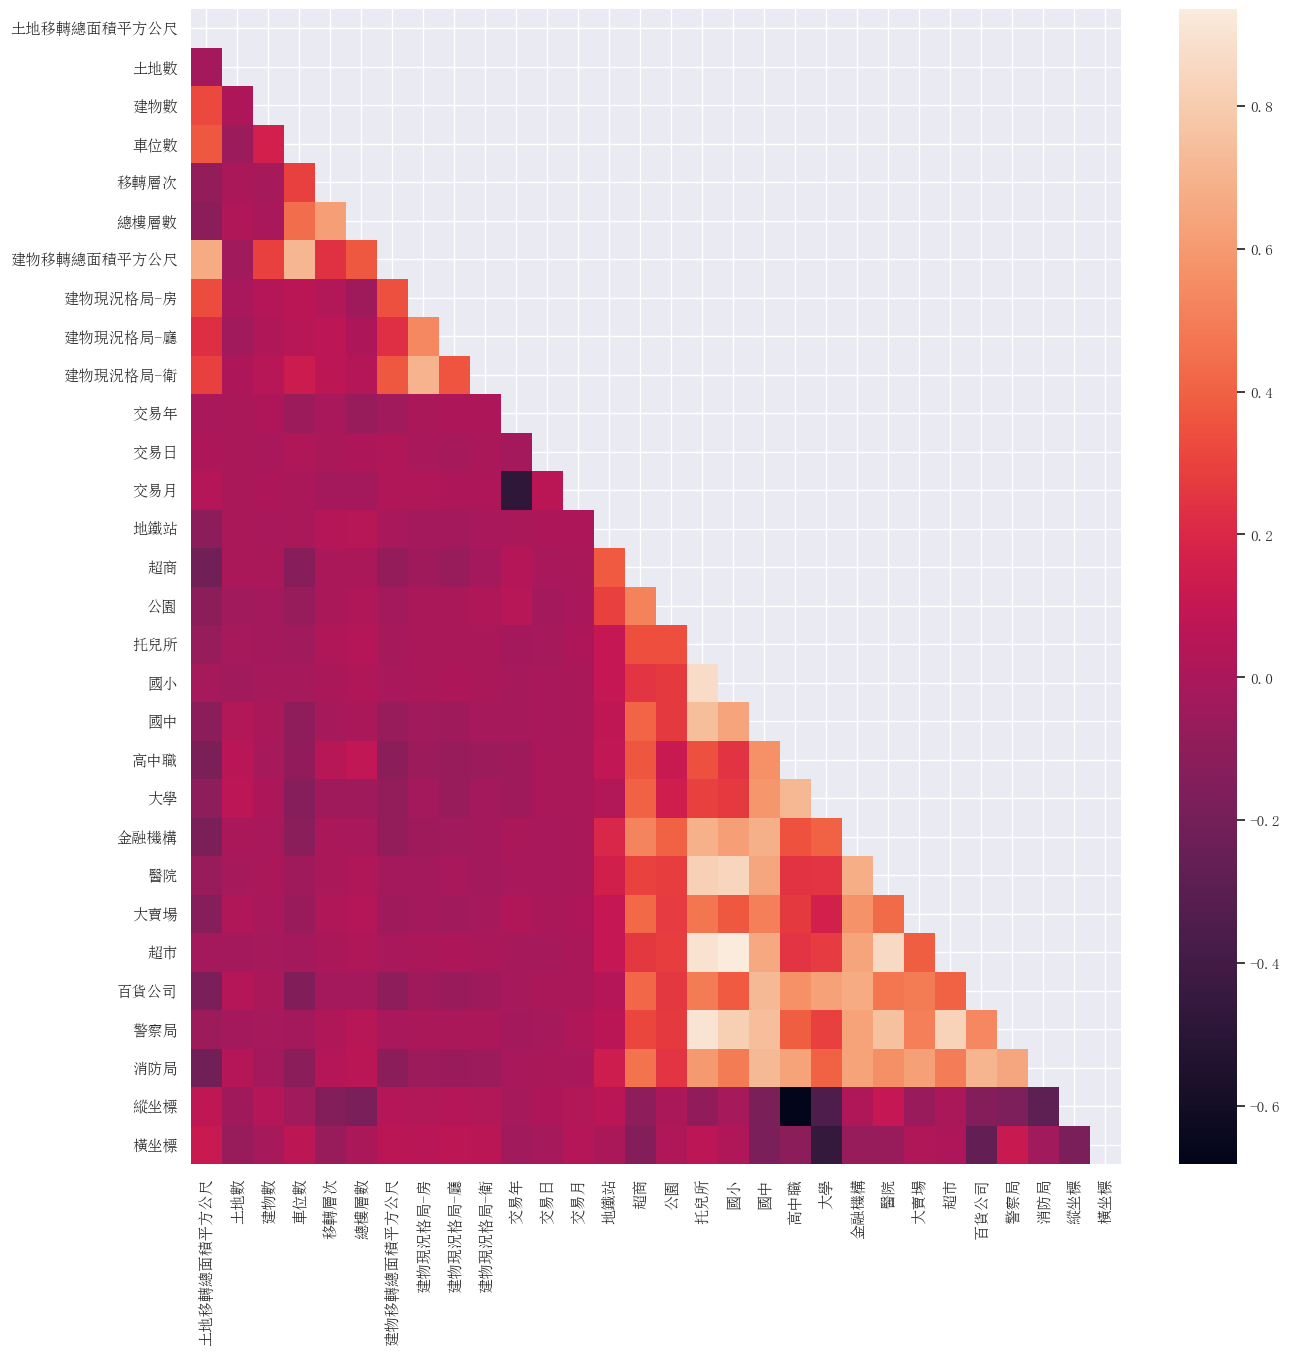

In [10]:
plt.figure(figsize=(15, 15)) 
corr_matrix = x_train.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask,annot=False)

## 各個特徵的分布曲線

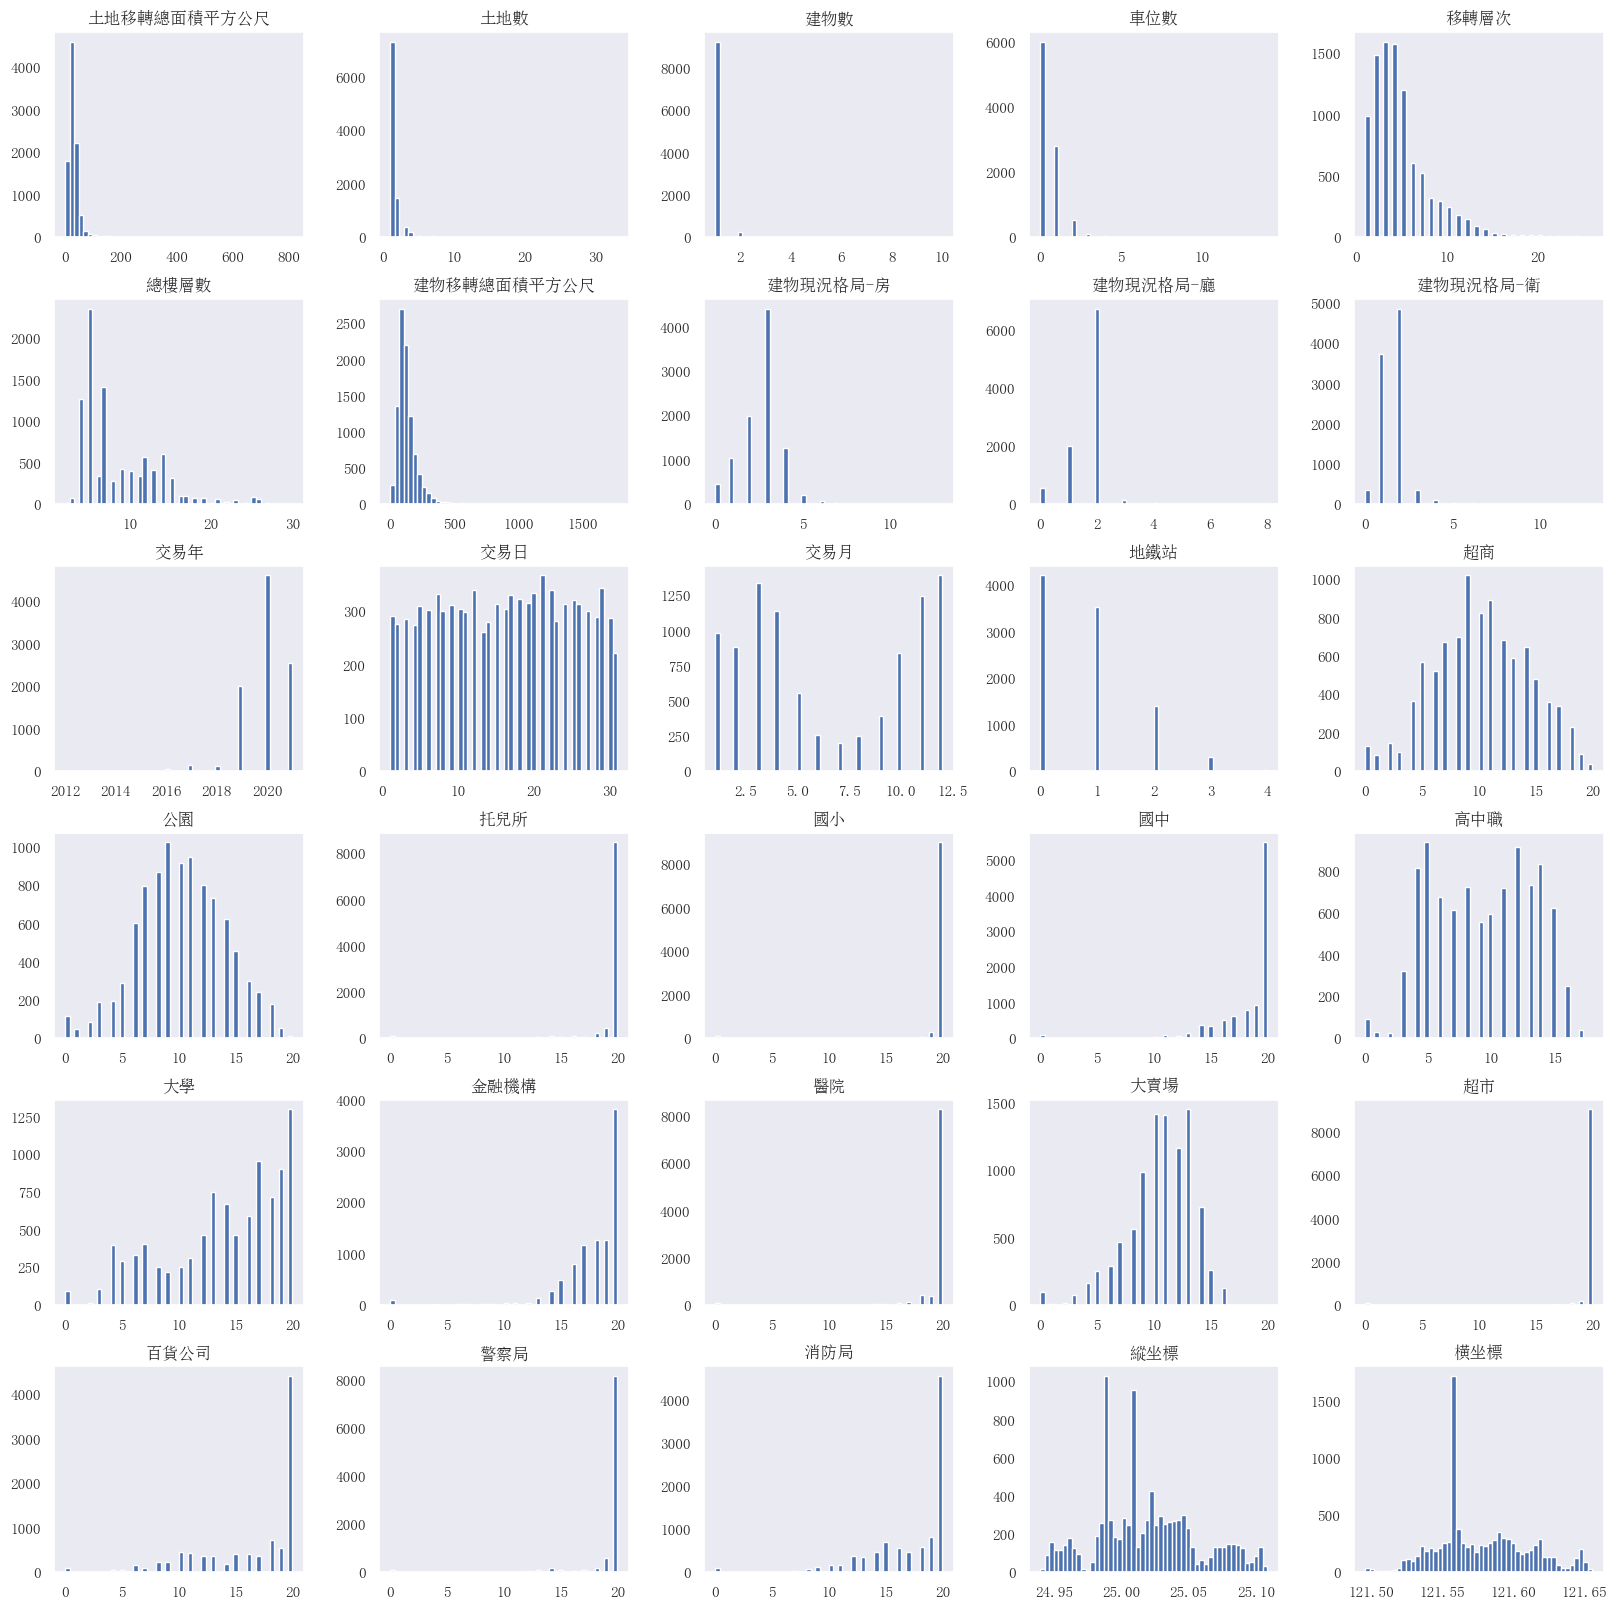

In [11]:
x_train.hist(figsize=(20, 20), bins=50, grid=False)
plt.show()

# 資料前處理

In [12]:
# 查看有無遺漏值
x_train.isnull().sum()

鄉鎮市區           0
交易標的           0
路名             0
土地移轉總面積平方公尺    0
都市土地使用分區       0
土地數            0
建物數            0
車位數            0
移轉層次           0
移轉層次項目         0
總樓層數           0
建物型態           0
主要用途           0
主要建材           0
建築完成年月         0
建物移轉總面積平方公尺    0
建物現況格局-房       0
建物現況格局-廳       0
建物現況格局-衛       0
建物現況格局-隔間      0
有無管理組織         0
交易年            0
交易日            0
交易月            0
地鐵站            0
超商             0
公園             0
托兒所            0
國小             0
國中             0
高中職            0
大學             0
金融機構           0
醫院             0
大賣場            0
超市             0
百貨公司           0
警察局            0
消防局            0
縱坐標            0
橫坐標            0
dtype: int64

In [13]:
# 查看資料型態
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   鄉鎮市區         9460 non-null   object 
 1   交易標的         9460 non-null   object 
 2   路名           9460 non-null   object 
 3   土地移轉總面積平方公尺  9460 non-null   float64
 4   都市土地使用分區     9460 non-null   object 
 5   土地數          9460 non-null   float64
 6   建物數          9460 non-null   float64
 7   車位數          9460 non-null   float64
 8   移轉層次         9460 non-null   int64  
 9   移轉層次項目       9460 non-null   object 
 10  總樓層數         9460 non-null   float64
 11  建物型態         9460 non-null   object 
 12  主要用途         9460 non-null   object 
 13  主要建材         9460 non-null   object 
 14  建築完成年月       9460 non-null   object 
 15  建物移轉總面積平方公尺  9460 non-null   float64
 16  建物現況格局-房     9460 non-null   int64  
 17  建物現況格局-廳     9460 non-null   int64  
 18  建物現況格局-衛     9460 non-null   int64  
 19  建物現況格局

## 簡化路名特徵

In [14]:
# 處理路名
def simplify_road_name(name):
    if '路' in name:
        return name.split('路')[0] + '路'
    elif '街' in name:
        return name.split('街')[0] + '街'
    else:
        return name

# 簡化路名欄位
x_train['簡化路名'] = x_train['路名'].apply(simplify_road_name)
# 刪除原始的路名欄位
x_train = x_train.drop(columns=['路名'])

# 簡化路名欄位
x_test['簡化路名'] = x_test['路名'].apply(simplify_road_name)
# 刪除原始的路名欄位
x_test = x_test.drop(columns=['路名'])

## 處理值為有無的二元變數

In [15]:
# 進行二元編碼
x_train['有無管理組織_encoded'] = x_train['有無管理組織'].map({'有': 1, '無': 0})
x_test['有無管理組織_encoded'] = x_test['有無管理組織'].map({'有': 1, '無': 0})
x_train['建物現況格局-隔間_encoded'] = x_train['建物現況格局-隔間'].map({'有': 1, '無': 0})
x_test['建物現況格局-隔間_encoded'] = x_test['建物現況格局-隔間'].map({'有': 1, '無': 0})

x_train = x_train.drop(columns=['有無管理組織'])
x_train = x_train.drop(columns=['建物現況格局-隔間'])
x_test = x_test.drop(columns=['有無管理組織'])
x_test = x_test.drop(columns=['建物現況格局-隔間'])

## 加入 Gaussian Basis Function Features

In [16]:
x_train['縣市'] = '台北市'

mu_x_all = []
mu_y_all = []
std_x_all = []
std_y_all = []
count_all = []

ngrid = 4 # divide into ngrid by ngrid

cities = ['台北市']
for acity in cities:
    dftrain_ks = x_train[x_train.縣市 == acity]
    print(acity, dftrain_ks.shape)
    coord_x = dftrain_ks.橫坐標.values
    coord_y = dftrain_ks.縱坐標.values
    
    xmin = min(coord_x)
    xmax = max(coord_x) + 0.1 # a convenient slack to fix boundary issue
    ymin = min(coord_y)
    ymax = max(coord_y) + 0.1 # a convenient slack to fix boundary issue
    
    xgrids = np.linspace(xmin, xmax, ngrid+1)
    ygrids = np.linspace(ymin, ymax, ngrid+1)
    
    
    for i in range(ngrid):
        for j in range(ngrid):
            x1 = xgrids[i]
            x2 = xgrids[i+1]
            y1 = ygrids[j]
            y2 = ygrids[j+1]
            tmpindx = (x1 <= coord_x) * (coord_x < x2)
            tmpindy = (y1 <= coord_y) * (coord_y < y2)
            tmpind = tmpindx * tmpindy
            npoints = np.sum(tmpind)
            if npoints < 20:
                print(f" - Only {npoints} points in grid {i}, {j}, skip")
                continue
            mu_x = np.mean(coord_x[tmpind])
            mu_y = np.mean(coord_y[tmpind])
            std_x = np.std(coord_x[tmpind])
            std_y = np.std(coord_y[tmpind])
            print(f"grid {i}, {j} N={npoints}; \tMean=({mu_x:.4f}, {mu_y:.4f})\tStd=({std_x:.4f}, {std_y:.4f})")
            
            mu_x_all.append(mu_x)
            mu_y_all.append(mu_y)
            std_x_all.append(std_x)
            std_y_all.append(std_y)

台北市 (9460, 42)
grid 0, 0 N=1425; 	Mean=(121.5494, 24.9883)	Std=(0.0123, 0.0045)
grid 0, 1 N=1674; 	Mean=(121.5532, 25.0297)	Std=(0.0063, 0.0232)
grid 0, 2 N=827; 	Mean=(121.5370, 25.0892)	Std=(0.0154, 0.0100)
 - Only 0 points in grid 0, 3, skip
grid 1, 0 N=2235; 	Mean=(121.5902, 24.9768)	Std=(0.0149, 0.0207)
grid 1, 1 N=2283; 	Mean=(121.5953, 25.0311)	Std=(0.0196, 0.0159)
grid 1, 2 N=229; 	Mean=(121.5656, 25.0856)	Std=(0.0054, 0.0070)
 - Only 0 points in grid 1, 3, skip
grid 2, 0 N=36; 	Mean=(121.6503, 25.0011)	Std=(0.0034, 0.0033)
grid 2, 1 N=751; 	Mean=(121.6405, 25.0308)	Std=(0.0084, 0.0092)
 - Only 0 points in grid 2, 2, skip
 - Only 0 points in grid 2, 3, skip
 - Only 0 points in grid 3, 0, skip
 - Only 0 points in grid 3, 1, skip
 - Only 0 points in grid 3, 2, skip
 - Only 0 points in grid 3, 3, skip


In [17]:
# 定義高斯基底函數
def gaussin_basis(coord_x, coord_y, mu_x_all, mu_y_all, std_x_all, std_y_all):
    ngf = len(mu_x_all)
    gf_all = np.zeros((coord_x.shape[0], ngf))
    
    for ii in range(ngf):
        mu_x = mu_x_all[ii]
        mu_y = mu_y_all[ii]
        std_x = std_x_all[ii]
        std_y = std_y_all[ii]
        
        # 計算高斯基底特徵
        tmpgf = np.exp(-(coord_x - mu_x) ** 2 / (2 * std_x ** 2) - (coord_y - mu_y) ** 2 / (2 * std_y ** 2))
        gf_all[:, ii] = tmpgf
    
    return gf_all

coord_x_train = x_train['橫坐標'].values
coord_y_train = x_train['縱坐標'].values

coord_x_test = x_test['橫坐標'].values
coord_y_test = x_test['縱坐標'].values

# 計算高斯基底特徵
gf_all_train = gaussin_basis(coord_x_train, coord_y_train, mu_x_all, mu_y_all, std_x_all, std_y_all)
gf_all_test = gaussin_basis(coord_x_test, coord_y_test, mu_x_all, mu_y_all, std_x_all, std_y_all)

# 將高斯特徵轉為 DataFrame，並命名欄位
gf_train_df = pd.DataFrame(gf_all_train, columns=[f'gauss_feature_{i}' for i in range(gf_all_train.shape[1])])
gf_test_df = pd.DataFrame(gf_all_test, columns=[f'gauss_feature_{i}' for i in range(gf_all_test.shape[1])])

# 將高斯特徵合併到原始 DataFrame
x_train = pd.concat([x_train.reset_index(drop=True), gf_train_df], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), gf_test_df], axis=1)

x_train = x_train.drop(columns=['縣市'])

## 將鄉鎮市區、簡化路名、都市土地使用分區、建物型態、主要建材、主要用途依房價進行排序 Label

In [18]:
# 對鄉鎮市區、簡化路名按照房價值進行 rank 並作為其 label
train_df = pd.concat([x_train, y_train], axis = 1)

rank_cols = ['鄉鎮市區', '簡化路名']

for col in rank_cols:
    
    rank_df = train_df.loc[:,[col,'單價元平方公尺']].groupby(col,as_index=False).mean().sort_values(by='單價元平方公尺').reset_index(drop=True)
    rank_df.loc[:,col+'_rank']=rank_df.index+1 
    
    if col == '鄉鎮市區':
        rank_city_df=rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df=train_df.merge(rank_city_df,how='left',on=col)

    else:
        rank_town_df=rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df=train_df.merge(rank_town_df,how='left',on=col)
            
train_df = train_df.drop(columns = ['單價元平方公尺'])
x_train = train_df

# 合併到原始的DataFrame
x_test = x_test.merge(rank_city_df, how='left', on = '鄉鎮市區')

# 合併到原始的 DataFrame
x_test = x_test.merge(rank_town_df, how='left', on = '簡化路名')

x_train = x_train.drop(columns=['鄉鎮市區'])
x_train = x_train.drop(columns=['簡化路名'])
x_test = x_test.drop(columns=['鄉鎮市區'])
x_test = x_test.drop(columns=['簡化路名'])

In [19]:
# 對都市土地使用分區、建物型態按照房價值進行 rank 並作為其 label
train_df = pd.concat([x_train, y_train], axis = 1)

rank_cols = ['都市土地使用分區', '建物型態']

for col in rank_cols:
    
    rank_df = train_df.loc[:,[col,'單價元平方公尺']].groupby(col,as_index=False).mean().sort_values(by='單價元平方公尺').reset_index(drop=True)
    rank_df.loc[:,col+'_rank']=rank_df.index+1 
    
    if col == '都市土地使用分區':
        rank_city_df = rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df = train_df.merge(rank_city_df,how='left',on=col)

    else:
        rank_town_df = rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df = train_df.merge(rank_town_df,how='left',on=col)
            
train_df = train_df.drop(columns = ['單價元平方公尺'])
x_train = train_df


# 合併到原始的DataFrame
x_test = x_test.merge(rank_city_df, how='left', on = '都市土地使用分區')

# 合併到原始的 DataFrame
x_test = x_test.merge(rank_town_df, how='left', on = '建物型態')

x_train = x_train.drop(columns=['都市土地使用分區'])
x_train = x_train.drop(columns=['建物型態'])
x_test = x_test.drop(columns=['都市土地使用分區'])
x_test = x_test.drop(columns=['建物型態'])

In [20]:
# 對主要建材、主要用途按照房價值進行 rank 並作為其 label
train_df = pd.concat([x_train, y_train], axis = 1)

rank_cols = ['主要建材', '主要用途']

for col in rank_cols:
    
    rank_df = train_df.loc[:,[col,'單價元平方公尺']].groupby(col,as_index=False).mean().sort_values(by='單價元平方公尺').reset_index(drop=True)
    rank_df.loc[:,col+'_rank']=rank_df.index+1 
    
    if col == '主要建材':
        rank_city_df = rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df = train_df.merge(rank_city_df,how='left',on=col)

    else:
        rank_town_df = rank_df.drop(['單價元平方公尺'],axis=1)

        # 合併到原始的DataFrame
        train_df = train_df.merge(rank_town_df,how='left',on=col)
            
train_df = train_df.drop(columns = ['單價元平方公尺'])
x_train = train_df

# 合併到原始的DataFrame
x_test = x_test.merge(rank_city_df, how='left', on = '主要建材')

# 合併到原始的 DataFrame
x_test = x_test.merge(rank_town_df, how='left', on = '主要用途')

x_train = x_train.drop(columns=['主要建材'])
x_train = x_train.drop(columns=['主要用途'])
x_test = x_test.drop(columns=['主要建材'])
x_test = x_test.drop(columns=['主要用途'])

## 加入新特徵

In [21]:
# 建物現況格局
x_train['建物現況格局'] = x_train[['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']].sum(axis=1)
x_test['建物現況格局'] = x_test[['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']].sum(axis=1)

# 將建築完成年月轉換成每個日期與最早日期之間的天數差
x_train['建築完成年月'] = pd.to_datetime(x_train['建築完成年月'])
min_date = x_train['建築完成年月'].min()
x_train['建築年齡'] = (x_train['建築完成年月'] - min_date).dt.days
x_train = x_train.drop(columns=['建築完成年月'])
x_test['建築完成年月'] = pd.to_datetime(x_test['建築完成年月'])
min_date = x_test['建築完成年月'].min()
x_test['建築年齡'] = (x_test['建築完成年月'] - min_date).dt.days
x_test = x_test.drop(columns=['建築完成年月'])

#平均房間面積
#x_train['平均房間面積'] = x_train['土地移轉總面積平方公尺']/x_train['建物現況格局']
#x_test['平均房間面積'] = x_test['土地移轉總面積平方公尺']/x_test['建物現況格局']
# 替換無窮值和 NaN
#x_train['平均房間面積'].replace([np.inf, -np.inf], np.nan, inplace=True)
#x_test['平均房間面積'].replace([np.inf, -np.inf], np.nan, inplace=True)

# # 將鄰近公共設施欄位的值相加創建新特徵
# # 想法:由於鄰近公共設施之間的相關性蠻高的，因此將這幾個欄位結合看看，
#x_train['便利性'] = x_train[['地鐵站', '超商', '金融機構', '大賣場']].sum(axis=1)
#x_test['便利性'] = x_test[['地鐵站', '超商', '金融機構', '大賣場']].sum(axis=1)
#x_train['教育'] = x_train[['托兒所', '國小', '國中', '高中職', '大學']].sum(axis=1)
#x_test['教育'] = x_test[['托兒所', '國小', '國中', '高中職', '大學']].sum(axis=1)

#「相對樓層高度」，可以用來表示樓層相對於建築物總高度的比例
# 想法是越高樓層視野會越好，房價可能越高
#x_train['相對樓層高度'] = x_train['移轉層次']/x_train['總樓層數']
#x_test['相對樓層高度'] = x_test['移轉層次']/x_test['總樓層數']

# x_train['房屋年齡'] = x_train['交易年'] - x_train['建築完成年月'].str[:4].astype(int)
# x_test['房屋年齡'] = x_test['交易年'] - x_test['建築完成年月'].str[:4].astype(int)

## 刪除不需要的欄位

In [22]:
x_train = x_train.drop(columns=['交易日'])
x_train = x_train.drop(columns=['交易月'])

x_test = x_test.drop(columns=['交易日'])
x_test = x_test.drop(columns=['交易月'])

## 其餘類別變數轉為 dummies 以便模型訓練

In [23]:
x_train_dum = pd.get_dummies(x_train)
x_train_dum

,土地移轉總面積平方公尺,土地數,建物數,車位數,移轉層次,總樓層數,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,交易年,地鐵站,超商,公園,托兒所,國小,國中,高中職,大學,金融機構,醫院,大賣場,超市,百貨公司,警察局,消防局,縱坐標,橫坐標,有無管理組織_encoded,建物現況格局-隔間_encoded,gauss_feature_0,gauss_feature_1,gauss_feature_2,gauss_feature_3,gauss_feature_4,gauss_feature_5,gauss_feature_6,gauss_feature_7,鄉鎮市區_rank,簡化路名_rank,都市土地使用分區_rank,建物型態_rank,主要建材_rank,主要用途_rank,建物現況格局,建築年齡,交易標的_房地(土地+建物),交易標的_房地(土地+建物)+車位,移轉層次項目_停車場,移轉層次項目_儲藏室,移轉層次項目_地下層,移轉層次項目_夾層,移轉層次項目_平台,移轉層次項目_機械房,移轉層次項目_無,移轉層次項目_見使用執照,移轉層次項目_見其他登記事項,移轉層次項目_走廊,移轉層次項目_通道,移轉層次項目_門廳,移轉層次項目_防空避難室,移轉層次項目_陽台,移轉層次項目_陽臺,移轉層次項目_電梯樓梯間,移轉層次項目_露台,移轉層次項目_騎樓
0,27.75,1.0,1.0,1.0,1,7.0,133.43,3,2,2,2019,1.0,7.0,2.0,20.0,20.0,19.0,12.0,17.0,15.0,20.0,7.0,20.0,13.0,20.0,16.0,24.957269,121.588026,1,1,1.937054e-13,1.559136e-09,5.021197e-41,6.355186e-01,0.000020,3.690943e-77,6.115659e-113,7.033608e-23,3,160,17,3,6,7,7,25166,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,9.57,1.0,1.0,0.0,5,6.0,40.34,1,1,1,2021,1.0,12.0,8.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,20.0,24.997141,121.558262,1,1,1.091971e-01,2.682346e-01,1.312545e-19,6.124235e-02,0.017169,1.220956e-35,2.313430e-163,3.324791e-24,11,430,19,3,6,4,3,17074,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,9.51,1.0,1.0,0.0,1,7.0,70.61,1,1,1,2020,0.0,6.0,7.0,20.0,20.0,18.0,11.0,19.0,15.0,18.0,6.0,20.0,11.0,20.0,13.0,24.953906,121.601050,1,1,1.531005e-17,1.149484e-15,2.382245e-44,4.173710e-01,0.000008,1.026214e-86,3.782167e-91,1.600437e-20,3,188,17,5,6,4,3,21358,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,23.67,1.0,1.0,1.0,10,15.0,143.83,3,2,2,2019,1.0,12.0,14.0,20.0,20.0,14.0,5.0,4.0,19.0,20.0,12.0,20.0,13.0,20.0,15.0,25.008046,121.557424,1,1,4.503718e-05,5.139027e-01,1.842689e-15,2.816640e-02,0.053819,9.368694e-28,5.450121e-167,4.635733e-23,6,159,19,4,6,7,7,21339,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,22.50,1.0,1.0,0.0,2,5.0,83.73,2,1,1,2021,2.0,4.0,13.0,20.0,20.0,15.0,5.0,15.0,19.0,20.0,10.0,20.0,16.0,18.0,13.0,24.986825,121.557424,0,1,7.628690e-01,1.434157e-01,6.030260e-24,7.795442e-02,0.003229,2.972527e-44,4.911652e-170,1.147024e-26,2,87,19,1,6,4,4,8122,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9455,29.01,1.0,1.0,0.0,3,6.0,130.96,3,2,2,2021,2.0,17.0,11.0,20.0,20.0,20.0,14.0,19.0,20.0,20.0,5.0,20.0,20.0,20.0,20.0,25.006934,121.584232,1,1,2.941952e-06,3.038432e-06,1.645807e-17,3.208356e-01,0.269356,1.182818e-30,4.647650e-85,8.202814e-12,10,335,26,3,6,4,7,9151,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9456,20.48,2.0,1.0,0.0,2,5.0,66.24,2,2,2,2020,0.0,6.0,9.0,20.0,20.0,20.0,14.0,20.0,15.0,20.0,13.0,20.0,18.0,20.0,20.0,24.968073,121.571759,0,1,6.104365e-06,3.655834e-04,8.487996e-34,4.233844e-01,0.000194,6.305008e-62,1.908497e-140,3.907791e-25,3,346,17,1,6,4,6,9901,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9457,136.19,1.0,1.0,3.0,3,9.0,433.73,4,2,3,2020,1.0,7.0,11.0,20.0,20.0,20.0,6.0,14.0,20.0,20.0,12.0,20.0,19.0,20.0,18.0,25.040072,121.595059,1,1,4.948164e-33,2.006376e-10,4.622747e-09,9.047137e-03,0.854514,1.917337e-16,2.925562e-89,3.132051e-07,9,403,17,3,8,4,9,18508,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9458,39.45,1.0,1.0,1.0,11,12.0,254.33,0,1,3,2019,1.0,11.0,9.0,20.0,20.0,17.0,8.0,6.0,17.0,18.0,12.0,20.0,18.0,20.0,18.0,25.016850,121.630579,1,1,4.208788e-19,8.999835e-34,4.063837e-20,3.877270e-03,0.131339,1.683553e-53,4.203850e-13,1.615670e-01,7,257,17,4,6,4,4,22546,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## 處理 test data

In [24]:
x_test_dum = pd.get_dummies(x_test)
x_test_dum.columns

Index(['土地移轉總面積平方公尺', '土地數', '建物數', '車位數', '移轉層次', '總樓層數', '建物移轉總面積平方公尺',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '交易年', '地鐵站', '超商', '公園', '托兒所',
       '國小', '國中', '高中職', '大學', '金融機構', '醫院', '大賣場', '超市', '百貨公司', '警察局',
       '消防局', '縱坐標', '橫坐標', '有無管理組織_encoded', '建物現況格局-隔間_encoded',
       'gauss_feature_0', 'gauss_feature_1', 'gauss_feature_2',
       'gauss_feature_3', 'gauss_feature_4', 'gauss_feature_5',
       'gauss_feature_6', 'gauss_feature_7', '鄉鎮市區_rank', '簡化路名_rank',
       '都市土地使用分區_rank', '建物型態_rank', '主要建材_rank', '主要用途_rank', '建物現況格局',
       '建築年齡', '交易標的_房地(土地+建物)', '交易標的_房地(土地+建物)+車位', '移轉層次項目_停車場',
       '移轉層次項目_夾層', '移轉層次項目_屋頂突出物', '移轉層次項目_平台', '移轉層次項目_無', '移轉層次項目_見使用執照',
       '移轉層次項目_見其他登記事項', '移轉層次項目_門廳', '移轉層次項目_陽台', '移轉層次項目_陽臺', '移轉層次項目_電梯樓梯間',
       '移轉層次項目_露台', '移轉層次項目_騎樓'],
      dtype='object')

In [25]:
intersection_columns = set(x_train_dum.columns).intersection(set(x_test_dum.columns))
x_test_dum = x_test_dum[intersection_columns]

C:\Users\jackyfirst\AppData\Local\Temp\ipykernel_11112\1339222515.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test_dum = x_test_dum[intersection_columns]


In [26]:
x_test_dum.shape

(2366, 60)

In [27]:
# Get missing columns in the training test
missing_cols = set(x_train_dum.columns) - set(x_test_dum.columns)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test_dum[c] = 0
# Ensure the order of column in the test set is in the same order than in train setxx
x_test_final = x_test_dum[x_train_dum.columns]

In [28]:
x_test_final.shape  # 變得跟 x_train_dum 欄位數量相同

(2366, 66)

In [29]:
x_train_final = x_train_dum
x_train_final.shape

(9460, 66)

# 模型訓練

## 特徵選擇

In [30]:
# 初始化 XGB 模型（預設參數）
feature_selector_model = XGBRegressor(
    n_estimators = 100, 
    max_depth = 3, 
    learning_rate = 0.1, 
    random_state = 42
)

# 訓練模型來獲取特徵重要性
feature_selector_model.fit(x_train_final, y_train)

# 獲取特徵重要性
feature_importances = pd.DataFrame({
    'Feature': x_train_final.columns,
    'Importance': feature_selector_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

# 篩選重要特徵（例如：重要性 > 0.01）
selected_features = feature_importances[feature_importances['Importance'] > 0.001]['Feature']
print("篩選出的重要特徵:\n", selected_features)

# 篩選後的訓練和測試數據
x_train_selected = x_train_final[selected_features]
x_test_selected = x_test_final[selected_features]

篩選出的重要特徵:
 39          簡化路名_rank
41          建物型態_rank
38          鄉鎮市區_rank
45               建築年齡
30    gauss_feature_0
7            建物現況格局-房
42          主要建材_rank
40      都市土地使用分區_rank
4                移轉層次
12                 超商
34    gauss_feature_4
31    gauss_feature_1
43          主要用途_rank
11                地鐵站
2                 建物數
9            建物現況格局-衛
5                總樓層數
27                橫坐標
6         建物移轉總面積平方公尺
33    gauss_feature_3
10                交易年
17                高中職
44             建物現況格局
32    gauss_feature_2
21                大賣場
35    gauss_feature_5
37    gauss_feature_7
65          移轉層次項目_騎樓
8            建物現況格局-廳
36    gauss_feature_6
3                 車位數
26                縱坐標
25                消防局
0         土地移轉總面積平方公尺
48         移轉層次項目_停車場
1                 土地數
28     有無管理組織_encoded
13                 公園
19               金融機構
18                 大學
16                 國中
Name: Feature, dtype: object


## 基礎模型

In [31]:
# # adaboost 31485
# tree = DecisionTreeRegressor(random_state=42)

# ada = AdaBoostRegressor(base_estimator=tree, random_state=42)

# param_grid = {
#     'base_estimator__max_depth': [100],
#     'n_estimators': [700],
#     'learning_rate': [0.1]
# }

# ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# ada.fit(x_train_final, y_train)

# print("Best parameters found: ", ada.best_params_)
# print("Lowest RMSE found: ", (-ada.best_score_)**0.5)

# y_pred = ada.predict(x_test_final)
# y_pred

In [32]:
# # xgboost 30940
# param_grid = {
#      'learning_rate': [0.1],
#      'max_depth': [7],
#      'n_estimators': [700]
# }

# xgr = GridSearchCV(estimator = XGBRegressor(), param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)
# xgr.fit(x_train_final, y_train)

# print("Best parameters found: ", xgr.best_params_)
# print("Lowest RMSE found: ", (-xgr.best_score_)**0.5)

# y_pred = xgr.predict(x_test_final)
# y_pred

## 堆疊模型

In [33]:
# 30498
# 1. 分離訓練集和驗證集
x_train, x_val, y_train, y_val = train_test_split(x_train_final, y_train, test_size = 0.2, random_state = 42)

# 2. 初始化基模型
# XGBoost GridSearchCV
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 7, 8],
    'n_estimators': [500, 700, 900]
}
xgb_model = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# LightGBM GridSearchCV
lgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 7, 8],
    'n_estimators': [500, 700, 900]
}
lgb_model = GridSearchCV(estimator=LGBMRegressor(), param_grid=lgb_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# CatBoost GridSearchCV
cat_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 7, 8],
    'n_estimators': [500, 700, 900]
}
cat_model = GridSearchCV(estimator=CatBoostRegressor(verbose=0), param_grid=cat_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# 用於儲存 Meta-Features 的資料
train_meta_features = np.zeros((x_train.shape[0], 3))  # 基模型數量
val_meta_features = np.zeros((x_val.shape[0], 3))
test_meta_features = np.zeros((x_test_final.shape[0], 3))

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# 3. 生成 Meta-Features
for i, (train_idx, valid_idx) in enumerate(kf.split(x_train)):
    X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
    y_tr, y_val_split = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # 訓練 XGBoost
    xgb_model.fit(X_tr, y_tr)
    train_meta_features[valid_idx, 0] = xgb_model.predict(X_val)
    val_meta_features[:, 0] += xgb_model.predict(x_val) / kf.n_splits
    test_meta_features[:, 0] += xgb_model.predict(x_test_final) / kf.n_splits
    
    # 訓練 LightGBM
    lgb_model.fit(X_tr, y_tr)
    train_meta_features[valid_idx, 1] = lgb_model.predict(X_val)
    val_meta_features[:, 1] += lgb_model.predict(x_val) / kf.n_splits
    test_meta_features[:, 1] += lgb_model.predict(x_test_final) / kf.n_splits
    
    # 訓練 CatBoost
    cat_model.fit(X_tr, y_tr)
    train_meta_features[valid_idx, 2] = cat_model.predict(X_val)
    val_meta_features[:, 2] += cat_model.predict(x_val) / kf.n_splits
    test_meta_features[:, 2] += cat_model.predict(x_test_final) / kf.n_splits

# 4. 訓練次級模型 (Meta 模型)
meta_model = Ridge()
meta_model.fit(train_meta_features, y_train)

# 在驗證集上評估
val_predictions = meta_model.predict(val_meta_features)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("堆疊模型驗證集 RMSE: ", val_rmse)

# 5. 預測測試集
y_pred = meta_model.predict(test_meta_features)
print("測試集預測完成！")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3977
[LightGBM] [Info] Number of data points in the train set: 6054, number of used features: 54
[LightGBM] [Info] Start training from score 180386.098179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3976
[LightGBM] [Info] Number of data points in the train set: 6054, number of used features: 54
[LightGBM] [Info] Start training from score 180047.080089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3980
[LightGBM] [Info] Number of data points in the train set: 6055, number of used features: 54
[LightGBM] [Info] Start training from score 180303.059352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
堆疊模型驗證集 RMSE:  30498.2956178845
測試集預測完成！


In [34]:
y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

# 輸出為 CSV 文件

In [35]:
output = pd.DataFrame({'Id': range(len(y_pred)), '單價元平方公尺': y_pred})
output.to_csv('r13725034_徐浚凱.csv', index=False)

In [36]:
output

,Id,單價元平方公尺
0,0,123902.641918
1,1,109207.169765
2,2,106818.200078
3,3,119323.372139
4,4,267548.913281
5,5,189235.735148
6,6,158812.743272
7,7,174141.034672
8,8,167767.727566
9,9,227343.196690
